In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [7]:
df_control = pd.read_excel("ab_testing_data.xlsx", sheet_name="Control Group")
df_control["Group"] = "Maximum Bidding"
df_control.head()

,Impression,Click,Purchase,Earning,Group
0,82529.45927,6090.07732,665.21125,2311.27714,Maximum Bidding
1,98050.45193,3382.86179,315.08489,1742.80686,Maximum Bidding
2,82696.02355,4167.96575,458.08374,1797.82745,Maximum Bidding
3,109914.40040,4910.88224,487.09077,1696.22918,Maximum Bidding
4,108457.76263,5987.65581,441.03405,1543.72018,Maximum Bidding


In [12]:
def check_df(dataframe):
    print("Shape\n", dataframe.shape)
    print("########################################################")
    print("Describe\n", dataframe.describe().T)
    print("########################################################")
    print("Confidence Internal of Purchase\n", sms.DescrStatsW(dataframe["Purchase"]).tconfint_mean())
check_df(df_control)

Shape
 (40, 5)
########################################################
Describe
               count         mean         std         min         25%  \
Impression 40.00000 101711.44907 20302.15786 45475.94296 85726.69035   
Click      40.00000   5100.65737  1329.98550  2189.75316  4124.30413   
Purchase   40.00000    550.89406   134.10820   267.02894   470.09553   
Earning    40.00000   1908.56830   302.91778  1253.98952  1685.84720   

                   50%          75%          max  
Impression 99790.70108 115212.81654 147539.33633  
Click       5001.22060   5923.80360   7959.12507  
Purchase     531.20631    637.95709    801.79502  
Earning     1975.16052   2119.80278   2497.29522  
########################################################
Confidence Internal of Purchase
 (508.0041754264924, 593.7839421139709)


In [13]:
df_test = pd.read_excel("ab_testing_data.xlsx", sheet_name="Test Group")
df_test["Group"] = "Average Bidding"
df_test.head()

,Impression,Click,Purchase,Earning,Group
0,120103.50380,3216.54796,702.16035,1939.61124,Average Bidding
1,134775.94336,3635.08242,834.05429,2929.40582,Average Bidding
2,107806.62079,3057.14356,422.93426,2526.24488,Average Bidding
3,116445.27553,4650.47391,429.03353,2281.42857,Average Bidding
4,145082.51684,5201.38772,749.86044,2781.69752,Average Bidding


In [15]:
check_df(df_test)

Shape
 (40, 5)
########################################################
Describe
               count         mean         std         min          25%  \
Impression 40.00000 120512.41176 18807.44871 79033.83492 112691.97077   
Click      40.00000   3967.54976   923.09507  1836.62986   3376.81902   
Purchase   40.00000    582.10610   161.15251   311.62952    444.62683   
Earning    40.00000   2514.89073   282.73085  1939.61124   2280.53743   

                    50%          75%          max  
Impression 119291.30077 132050.57893 158605.92048  
Click        3931.35980   4660.49791   6019.69508  
Purchase      551.35573    699.86236    889.91046  
Earning      2544.66611   2761.54540   3171.48971  
########################################################
Confidence Internal of Purchase
 (530.5670226990063, 633.645170597929)


In [16]:
df_final = pd.concat ([df_control, df_test])
df_final.groupby("Group").agg({"Purchase": "mean"})

,Purchase
Group,
Average Bidding,582.10610
Maximum Bidding,550.89406


### 1. Assumpiton Control

* 1.1 Normality Assumption
* 1.2 Homogeneity of Variance

In [18]:
############################
# 1.1 Normality Assumption
############################

from scipy.stats import shapiro

test_statistic, pvalue = shapiro(df_final.loc[df_final["Group"] == "Average Bidding", "Purchase"])
print('Average Bidding Group - Test Statistic = %.4f, Average Bidding Group -  p-value = %.4f' % (test_statistic, pvalue))

test_statistic, pvalue = shapiro(df_final.loc[df_final["Group"] == "Maximum Bidding", "Purchase"])
print('Maximum Bidding Group - Test Statistic = %.4f, Maximum Bidding Group - p-value = %.4f' % (test_statistic, pvalue))

# p-value < 0.05'ten HO reject.
# p-value > 0.05 H0 does not reject.

# H0 is accepted for both campaigns (p> 0.05).
# The number of purchases variable for both campaign types conforms to the normal distribution.

Average Bidding Group - Test Statistic = 0.9589, Average Bidding Group -  p-value = 0.1541
Maximum Bidding Group - Test Statistic = 0.9773, Maximum Bidding Group - p-value = 0.5891


In [19]:
############################
# 1.2 Homogeneity of Variance Assumption
############################

# H0: variances are homogeneous (no significant difference.)
# H1: variances are not homogeneous (significant difference.)

from scipy import stats
stats.levene(df_final.loc[df_final["Group"] == "Average Bidding", "Purchase"],
             df_final.loc[df_final["Group"] == "Maximum Bidding", "Purchase"])


# p-value < 0.05'ten HO reject.
# p-value > 0.05 H0 does not reject.

# H0 is accepted (p> 0.05). The variance of the groups is equal.
# The t-test can be used because it provides both a normal distribution and variance homogeneity.

LeveneResult(statistic=2.6392694728747363, pvalue=0.10828588271874791)

### 2. Application of the Hypothesis

In [20]:
# H0: M1 = M2 (... There is no statistically significant difference between the average purchases
#of the "Maximum Bidding" campaign and the average purchases of the "Average bidding" campaign.)

# H1: M1! = M2 (... exists)

test_statistic, pvalue = stats.ttest_ind(df_final.loc[df_final["Group"] == "Average Bidding", "Purchase"],
                                        df_final.loc[df_final["Group"] == "Maximum Bidding", "Purchase"],
                                           equal_var=True)


print('Test Statistic = %.4f, p-value = %.4f' % (test_statistic, pvalue))

# p-value <  0.05 HO reject.
# p-value >  0.05 H0 does not reject.
# H0 is accepted. There is no statistically significant difference between the average purchase of the two groups.

Test Statistic = 0.9416, p-value = 0.3493


The test should be tested on larger samples.The 40 observations are very close to the minimum sample size of 30.

[]

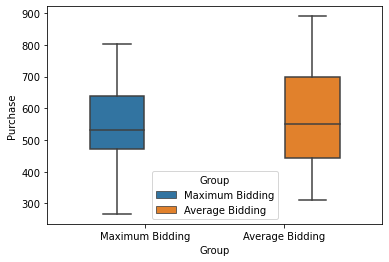

In [22]:
import seaborn as sns
sns.boxplot(x="Group", y="Purchase", hue="Group", data=df_final)
plt.plot()

In [23]:
df_final.groupby("Group").agg({"Purchase":"mean","Impression":"mean","Click":"mean", "Earning":"mean" }).reset_index()

,Group,Purchase,Impression,Click,Earning
0,Average Bidding,582.10610,120512.41176,3967.54976,2514.89073
1,Maximum Bidding,550.89406,101711.44907,5100.65737,1908.56830
